<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/LRA/LRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References  
[1] https://github.com/lsorber/recommender-system-tutorial/blob/master/recommender-system.ipynb

#  1M movie ratings data download


In [2]:
from urllib.request import urlretrieve
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-1m.zip'
urlretrieve(url + filename, filename);

## dataset info  
  
- 출처: [url](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt)  



### RATINGS FILE DESCRIPTION   
 - UserID::MovieID::Rating::Timestamp

 - UserIDs range between 1 and 6040 
 - MovieIDs range between 1 and 3952
 - Ratings are made on a 5-star scale (whole-star ratings only)
 - Timestamp is represented in seconds since the epoch as returned by time(2)  
   평점이 매겨진 뒤부터 얼마나 시간이 지났는지를 보여준다
 - Each user has at least 20 ratings


### USERS FILE DESCRIPTION  
  
 - Gender is denoted by a "M" for male and "F" for female
 - Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"  
      
- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"


### MOVIES FILE DESCRIPTION   

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist 

 zip files containing csv-like tables. Unfortunately, the 1M data set is provided in a less standard format, and requires a bit of parsing before we can hand it off to pandas for reading.

평점 매김 파일로 데이터 전처리


In [3]:
# Read the movie ratings from the zip file.
import pandas as pd
from zipfile import ZipFile
from io import StringIO
filename = 'ml-1m.zip'
with ZipFile(filename, 'r') as ml:
    if 'small' in filename:
        csv = filename.replace('.zip', '') + '/ratings.csv'
        df = pd.read_csv(ml.open(csv))
    elif '1m' in filename:
        csv = filename.replace('.zip', '') + '/ratings.dat'
        with ml.open(csv) as csv:
            data = ''.join(map(lambda line: line.decode('utf-8'), csv.readlines()))
            df = pd.read_csv(StringIO(data), sep='::', engine='python',
                             header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [80]:
df['userId']

0             1
1             1
2             1
3             1
4             1
           ... 
1000204    6040
1000205    6040
1000206    6040
1000207    6040
1000208    6040
Name: userId, Length: 1000209, dtype: category
Categories (6040, int64): [1, 2, 3, 4, ..., 6037, 6038, 6039, 6040]

In [83]:
print(df['movieId'])
print(len(df['movieId']))

0          1193
1           661
2           914
3          3408
4          2355
           ... 
1000204    1091
1000205    1094
1000206     562
1000207    1096
1000208    1097
Name: movieId, Length: 1000209, dtype: category
Categories (3706, int64): [1, 2, 3, 4, ..., 3949, 3950, 3951, 3952]
1000209


In [5]:
df.count() # 백만 개 있다.

userId       1000209
movieId      1000209
rating       1000209
timestamp    1000209
dtype: int64

#2. Preprocess the data set

As a preprocessing step, we'll translate the user and movie ids to zero-based consecutive user and movie indices.  
  
- Todo: userId --> indices, movieId --> movie indices  
- step (1):  convert these columns to a categorical data type  
- step (2):  use the category indices as user and movie indices.

In [19]:
df.dtypes

userId       category
movieId      category
rating          int64
timestamp       int64
dtype: object

In [18]:
df.userId = df.userId.astype('category')
df.movieId = df.movieId.astype('category')
df.dtypes

userId       category
movieId      category
rating          int64
timestamp       int64
dtype: object

In [35]:
df.movieId.describe()

count     1000209
unique       3706
top          2858
freq         3428
Name: movieId, dtype: int64

The `userId` and `movieId` columns may contain non-consecutive numbers.
Here, we add the category codes to the DataFrame as a zero-based consecutive version of these ids.  
  
- Id 들에 비연속적 수 --> 0 기반의 연속 수 버젼으로 코드 추가

In [20]:
df['userIndex'] = df.userId.cat.codes
df['movieIndex'] = df.movieId.cat.codes
df.head()

,userId,movieId,rating,timestamp,userIndex,movieIndex
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162


In [34]:
df.select_dtypes(include=['int64'])

,rating,timestamp
0,5,978300760
1,3,978302109
2,3,978301968
3,4,978300275
4,5,978824291
...,...,...
1000204,1,956716541
1000205,5,956704887
1000206,5,956704746
1000207,4,956715648


# 3. Split the data set into train, validation and test

we should split it into:  
  
- a training set for optimizing our model's parameters,
  
- a validation set for optimizing our model's hyperparameters (such as the number of iterations and amount of regularization), and
  
- a test set for estimating the generalization performance of the resulting model.

In [25]:
# a feature matrix (prefixed by an uppercase X) and a vector of labels (prefixed by a lowercase y)

try:
    from sklearn.model_selection import train_test_split  # sklearn 0.18+
except:
    from sklearn.cross_validation import train_test_split

###################################################################################################################################################
######################################################## train set split  #########################################################################
###################################################################################################################################################

X_train, X_test, y_train, y_test = train_test_split(df[['userIndex', 'movieIndex']].values, df['rating'].values, test_size = 0.2, random_state=42)

###################################################################################################################################################
######################################################## val set split  #########################################################################
###################################################################################################################################################

X_validation, X_test, y_validation, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=42)

###################################################################################################################################################
######################################################## 유저 수, 영화 수  #########################################################################
###################################################################################################################################################

n_users, n_movies = df.userIndex.max() + 1, df.movieIndex.max() + 1

print('데이터셋 안에 {n_users} 명의 사용자와  {n_movies} 개의 영화가 있다.'.format(n_users=n_users, n_movies=n_movies))
print('\n트레이닝, 검증, 테스트 인덱스의 사이즈는 각각 {train_shape}, {validation_shape} and {test_shape}'.format(
    train_shape=X_train.shape, validation_shape=X_validation.shape, test_shape=X_test.shape))
print('\n평점label (ratings)의 범위는 {y_min} 부터 {y_max}까지 있다.'.format(y_min=y_train.min(), y_max=y_train.max()))

데이터셋 안에 6040 명의 사용자와  3706 개의 영화가 있다.

트레이닝, 검증, 테스트 인덱스의 사이즈는 각각 (800167, 2), (100021, 2) and (100021, 2)

평점label (ratings)의 범위는 1 부터 5까지 있다.


# 4 Implementations  
  
- the RMSE function,
  
- the L2 function,
  
- the sigmoid function,
  
- the prediction function $\hat{R}'$
  
- the loss function.

In [45]:
# We'll be using a thin wrapper around numpy called autograd.
# Later on, autograd will provide us with a gradient of the loss function automatically.
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline

## 4.1 RMSE

In [47]:
test1 = np.arange(6).reshape(2,3)
test2 = np.arange(6).reshape(2,3)

print(test1-test2) # 단순하게 표현해도 행렬 간 연산 가능

[[0 0 0]
 [0 0 0]]


In [50]:
def rmse(predicted_ratings, true_ratings):
    
    error = predicted_ratings - true_ratings # 사실 제곱을 취할 것이기 때문에 순서는 상관 없다,
    rmse = np.sqrt((error**2).mean())

    return rmse

# Test if our implementation works.
assert rmse(np.array([1, 5]), np.array([1, 5])) == 0.  # Perfect predictions.
assert rmse(np.array([2, 5]), np.array([4, 3])) == 2.  # Two stars incorrect.

## 4.2 L2

In [60]:
def L2(userfeatures, moviefeatures):
   
    L2 = np.sum(userfeatures**2)+np.sum(moviefeatures**2)

    return L2


# Test if our implementation works.
userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])

assert L2(userfeatures, moviefeatures) == 11.5

## 4.3 sigmoid

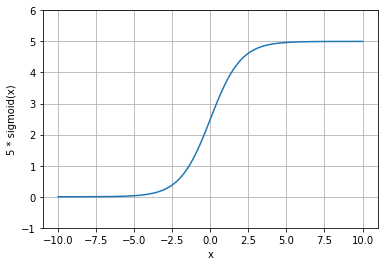

In [64]:
def sigmoid(x):

    sigmoid = 1/(1+np.exp(-x))

    return sigmoid

x = np.linspace(-10., 10., 100)
y = 5. * sigmoid(x)
plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('5 * sigmoid(x)')
plt.ylim(-1, 6); plt.grid()

## 4.4 predicted function $\hat{R}$

In [75]:
def predict_ratings(userfeatures, moviefeatures, userindices, movieindices):

    """
    Args:
            userfeatures (np.ndarray): An n_users x k array, where k is the number of features per user.
            moviefeatures (np.ndarray): An n_movies x k array, where k is the number of features per movie.
            userindices (np.array): An array of user indices to predict ratings for.
            movieindices (np.array): An array of movie indices to predict ratings for.

    """

    # 5 * sigmoid(\sum_i userfeatures[userindex, i] * moviefeatures[movieindex, i])

    predicted_ratings = 5*sigmoid(np.sum(userfeatures[userindices,:]*moviefeatures[movieindices,:],axis=1)) # axis=1

    # 포인트: sum(dot product btn a and b)

    return predicted_ratings

userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])
userindices = np.array([0, 0, 1, 1])
movieindices = np.array([0, 0, 1, 1])
assert np.all(predict_ratings(userfeatures, moviefeatures, userindices, movieindices) >= 0.) 
assert np.all(predict_ratings(userfeatures, moviefeatures, userindices, movieindices) <= 5.)
print(predict_ratings(userfeatures, moviefeatures, userindices, movieindices))
assert np.all(np.isclose(predict_ratings(userfeatures, moviefeatures, userindices, movieindices), np.array([4.404, 4.404, 0.596, 0.596]), rtol=1e-3))  

[4.40398539 4.40398539 0.59601461 0.59601461]


## 4.5 Loss

In [79]:
def loss(weights, userindices=None, movieindices=None, true_ratings=None, regL2=0.):
    """Given the user and movie features, predict the ratings and compare with the true ratings.
    
    Args:
        weights (tuple): The user features and movie features as a tuple of the form (np.ndarray, np.ndarray).
        userindices (np.array): An array of user indices to predict ratings for.
        movieindices (np.array): An array of movie indices to predict ratings for.
        true_ratings (np.array): A numpy array containing the true ratings.
        regL2 (float): The coefficient for the L2 regularization term of the loss function.
    
    Returns:
        np.array: The RMSE between the predicted ratings generated with `predict_ratings`,
            and the given `true_ratings`, summed with regL2 times the L2 norm of the weights:
            
                rmse(predicted_ratings, true_ratings) + regL2 * L2(userfeatures, moviefeatures)
    """
    # Unpack the weights tuple into the user and movie features to pass to `predict_ratings`.
    userfeatures, moviefeatures = weights

    """
    (1) 예측값 R_hat
    (2) rmse
    (3) L2

    """
    # Predict the ratings.
    # TODO: predicted_ratings =
    predicted_ratings = predict_ratings(userfeatures,moviefeatures,userindices,movieindices)

    # Compute the loss as the RMSE between the predicted and the true ratings,
    rmse_value = rmse(predicted_ratings, true_ratings)

    # summed with regL2 times the L2 norm of the user- and moviefeatures.
    L2_value = L2(userfeatures,movieindices)
    
    # TODO: loss = 
    loss= rmse_value +regL2*L2_value

    return loss

# Test if our implementation works.
userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])
userindices = np.array([0, 0, 1, 1])
movieindices = np.array([0, 0, 1, 1])
true_ratings = np.array([2., 2., -2., 0.])
assert np.isclose(loss((userfeatures, moviefeatures), userindices, movieindices, true_ratings), 2.159, rtol=1e-03)